<a href="https://colab.research.google.com/github/dpcks/playdata/blob/main/Machine_Learning/09_%EB%B9%84%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5_%EC%B0%A8%EC%9B%90%EC%B6%95%EC%86%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

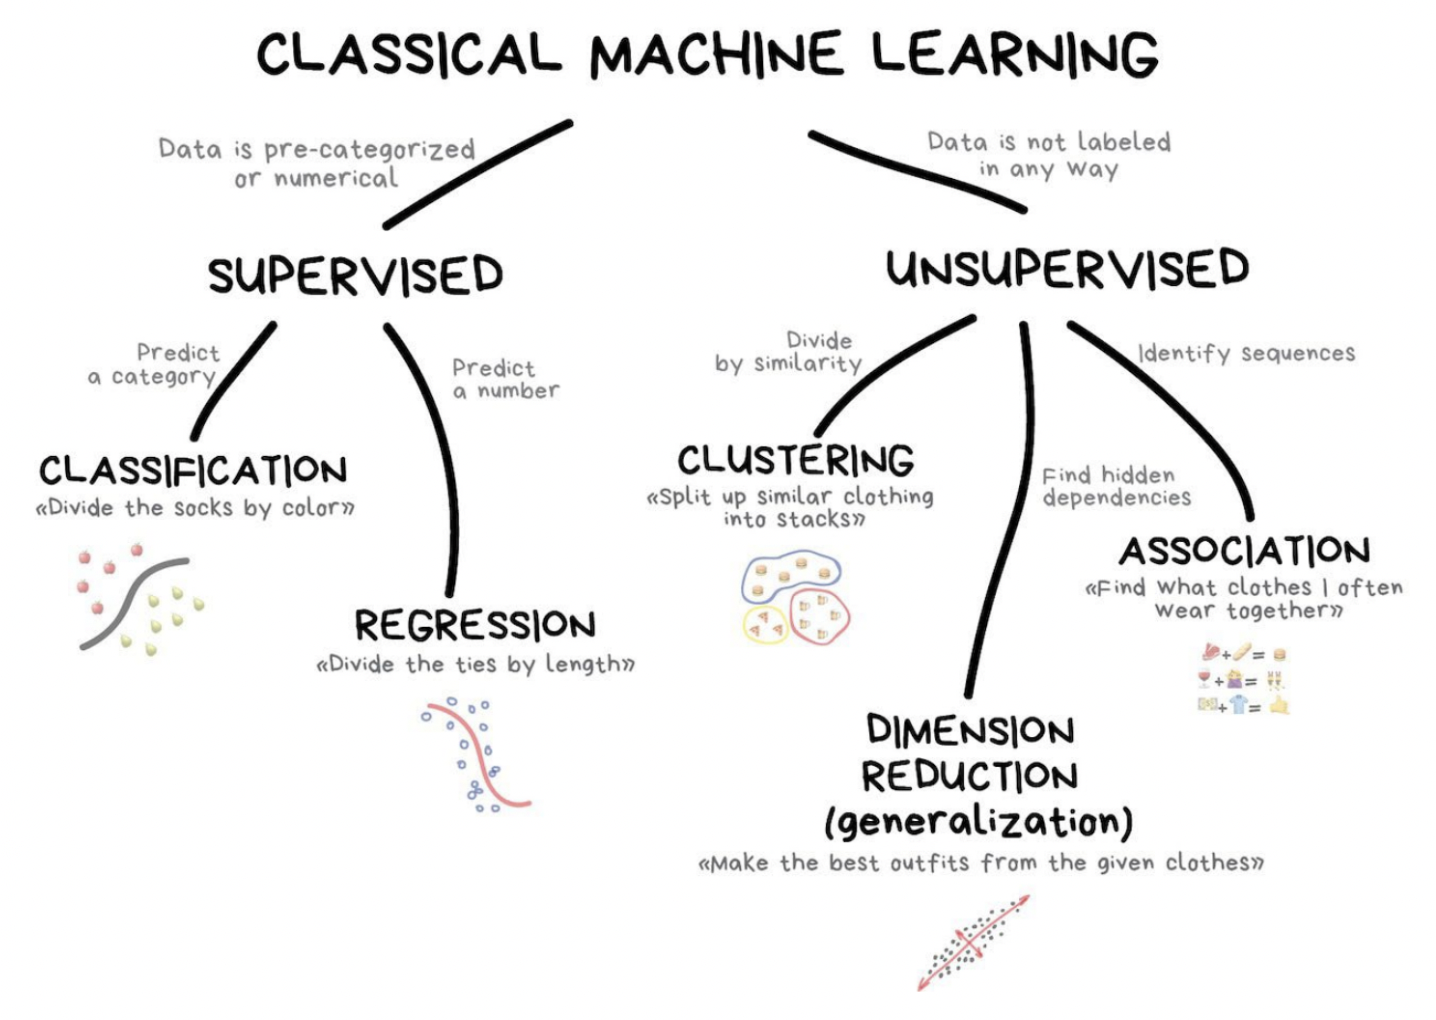

# 지도학습 vs 비지도학습

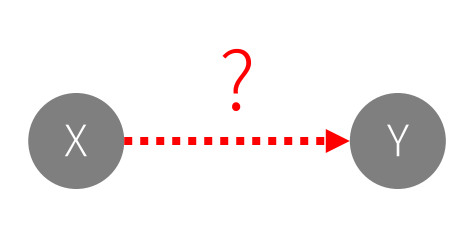

- 비지도 학습의 기본 아이디어는 X를 설명할수 있는 z가 존재한다고 가정하고 학습 진행
- 여기서 z는 잠재변수라고 한다.

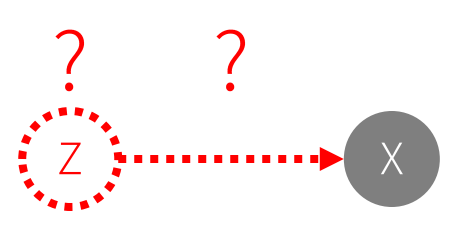

# 차원의 저주
- 차원이 증가하면서 학습데이터 수에 비해 특성의 차원수가 많아져서 성능이 저하되는 현상


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/data/"
SEED = 42

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
df = pd.read_csv(f"{DATA_PATH}titanic.csv")
# 결측치 미리 채우기
df.age = df.age.fillna(df.age.median()) # age 중앙값
df.fare = df.fare.fillna(df.fare.median()) # fare 중앙값
df.cabin = df.cabin.fillna("UNK") # cabin 임의의 문자열로 채우기
df.embarked = df.embarked.fillna(df.embarked.mode()[0]) # embarked 최빈값
# 학습에 바로 사용가능한 특성
cols = ["pclass","age","sibsp","parch","fare"]
features = df[cols]
# 범주형 one-hot encoding
cols = ["gender","embarked"]
enc = OneHotEncoder()
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
features = pd.concat([features,tmp],axis=1) # 특성
y_train = df["survived"] # 정답값
features.head()

,pclass,age,sibsp,parch,fare,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [ ]:
df.nunique()

passengerid    1309
survived          2
pclass            3
name           1307
gender            2
age              98
sibsp             7
parch             8
ticket          929
fare            281
cabin           187
embarked          3
dtype: int64

In [ ]:
cols = ["ticket","cabin"]

enc = OneHotEncoder()

sparse_features = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
x_train = pd.concat([features,sparse_features],axis=1)
x_train


,pclass,age,sibsp,parch,fare,gender_female,gender_male,embarked_C,embarked_Q,embarked_S,...,cabin_F E69,cabin_F G63,cabin_F G73,cabin_F2,cabin_F33,cabin_F38,cabin_F4,cabin_G6,cabin_T,cabin_UNK
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,28.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1305,1,39.0,0,0,108.9000,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1306,3,38.5,0,0,7.2500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1307,3,28.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
model = LGBMClassifier(random_state=SEED)
cv = KFold(n_splits=5,shuffle=True,random_state=SEED)

scores = cross_val_score(model,x_train,y_train,cv=cv , scoring="roc_auc",n_jobs=-1)
scores.mean() # 차원축소하기전 점수

0.8900131161304283

# PCA (Piincipal Component Analysis)
- 주성분 분석
- 새로 파생된 주성분이 특성이다!
- 주요 아규먼트
    - n_component : 주성분의 수
    - whiten : 스케일링 여부(기본값 False)
    

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components= 200,random_state=SEED) # 200개로 차원축소
pca.fit(sparse_features)

PCA(n_components=200, random_state=42)

In [ ]:
# (200개) 주성분에 의해 설명되는 분산비율
sum(pca.explained_variance_ratio_)

0.5256536154235844

In [ ]:
tmp = pd.DataFrame(pca.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features,tmp],axis=1)
x_train.head()

,pclass,age,sibsp,parch,fare,gender_female,gender_male,embarked_C,embarked_Q,embarked_S,...,pca_190,pca_191,pca_192,pca_193,pca_194,pca_195,pca_196,pca_197,pca_198,pca_199
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,...,-0.004645,0.003722,0.004964,-0.004865,0.000255,-0.003978,0.003764,0.003282,0.004359,0.000014
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,...,0.000134,0.000120,0.000408,-0.000133,0.000085,-0.000154,-0.000293,-0.000161,0.000067,-0.000134
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,...,-0.003670,-0.006089,0.005653,-0.002627,0.002487,-0.010510,0.003361,-0.001623,-0.002790,-0.001930
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,...,0.000261,0.000298,0.000126,-0.000126,-0.000023,0.000125,-0.000278,0.000349,0.000065,0.000297
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,...,-0.001234,0.004994,0.001616,0.004335,-0.002837,-0.002673,0.004364,0.000048,0.006741,-0.003813


In [ ]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv=cv , scoring="roc_auc",n_jobs=-1)
scores.mean()

0.9013099786869494

In [ ]:
pca = PCA(n_components=sparse_features.shape[1],random_state=SEED)
pca.fit(sparse_features)
sum(pca.explained_variance_ratio_)

1.0000000000000056

In [ ]:
pca.explained_variance_ratio_ # 1번째가 원본데이터를 가장 잘설명할수있는 주성분 비율

array([1.26933943e-01, 6.48572553e-03, 6.01737999e-03, ...,
       2.70709680e-35, 2.46050143e-35, 2.35032388e-35])

In [ ]:
components  = np.arange(200,901,50)
for c in components:
    v = sum(pca.explained_variance_ratio_[:c])
    print(f"{c}개 주성분: {v}")

200개 주성분: 0.527159387064588
250개 주성분: 0.5818057014232519
300개 주성분: 0.6343174560575218
350개 주성분: 0.6634783108864314
400개 주성분: 0.6908014680657634
450개 주성분: 0.7181246252450953
500개 주성분: 0.7454477824244273
550개 주성분: 0.7727709396037593
600개 주성분: 0.8000940967830913
650개 주성분: 0.8274172539624233
700개 주성분: 0.8547404111417553
750개 주성분: 0.8820635683210872
800개 주성분: 0.9093867255004192
850개 주성분: 0.9367098826797512
900개 주성분: 0.9640330398590832


In [ ]:
pca = PCA(n_components=800,random_state=SEED)
pca.fit(sparse_features)

PCA(n_components=800, random_state=42)

In [ ]:
tmp = pd.DataFrame(pca.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features,tmp],axis=1)
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv=cv , scoring="roc_auc",n_jobs=-1)
scores.mean()

0.9103647522510643

In [ ]:
def get_score(decomp ,features,sparse_features):
    tmp = pd.DataFrame(decomp.transform(sparse_features)).add_prefix("decomp_")
    x_train = pd.concat([features,tmp],axis=1)
    model = LGBMClassifier(random_state=SEED)
    scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
    return scores.mean()

In [ ]:
get_score(pca,features,sparse_features)

0.9103647522510643

# KernelPCA
- 비선형 결합방식
- kernel을 이용해서 비선형으로 결합
    - linear(default값, pca랑 같다)
    - poly(다항식)
    - rbf
    - sigmoid
    - cosine

In [ ]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=100,kernel="cosine",n_jobs=-1,random_state=SEED)
kpca.fit(sparse_features)

KernelPCA(kernel='cosine', n_components=100, n_jobs=-1, random_state=42)

In [ ]:
get_score(kpca,features,sparse_features)

0.9224232825859108

# 행렬분해
- 하나의 행렬을 여러개의 행렬의 곱으로 나타내는것

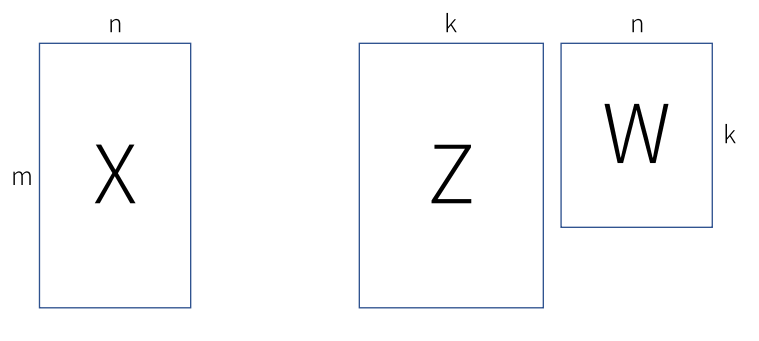

# SVD (Singular Value Decomposition)
- 특이값 분해


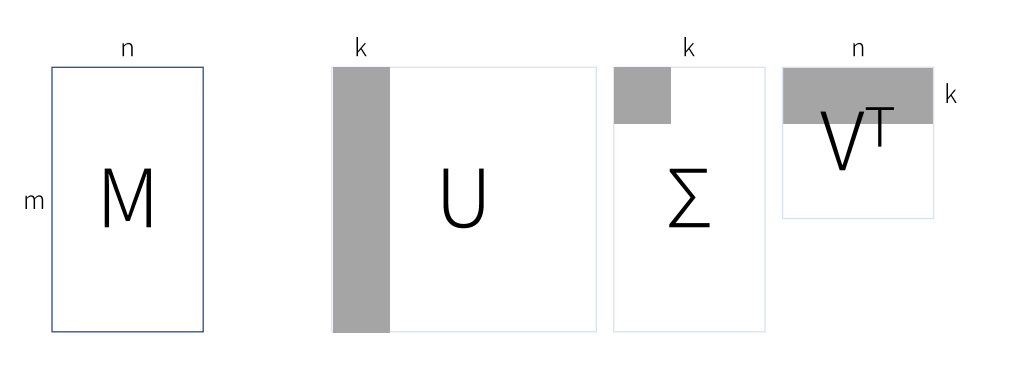

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100,random_state=SEED)
svd.fit(sparse_features)

TruncatedSVD(n_components=100, random_state=42)

In [ ]:
sum(svd.explained_variance_ratio_)

0.3929530650654831

In [ ]:
get_score(svd,features,sparse_features)

0.9047766578047938

- 이상치를 탐색하는데 응용할수 있다.

# NMF (Non-negative Matrix Factorization)
- z와 w의 0이상만

In [ ]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=100,random_state=SEED,max_iter=500)
nmf.fit(sparse_features)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


NMF(max_iter=500, n_components=100, random_state=42)

In [ ]:
(nmf.components_ < 0).sum()

0

In [ ]:
get_score(nmf,features,sparse_features)

0.8901839296125882

- LDA (Linear Discriminant Analysis)
    - y값을 분리하는데 사용한는 방법 
    - 백화점데이터셋에서 좋은 성능
    - 책에 있음

# Random Projection
- 데이터 포인트간에 거리를 유지되도록 하면서 특성의 차원을 저차원으로 투영
- GRP(Gaussian Random Projection)
    - 일반적인 데이터에 사용
- SRP(Sparse Random Projection)
    - 0이 많은데이터에 사용


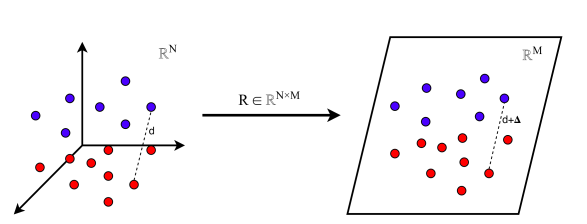

- GaussianRandomProjection
    - n_components : 차원수
        - "auto": 기본값, eps 에 따라 자동으로 차원수를 결정
    - eps: 입실론값
        - 값이 작을수록 차원이 높아진다.
        

In [ ]:
from sklearn.random_projection import GaussianRandomProjection
grp = GaussianRandomProjection(eps=0.4,random_state=SEED)
grp.fit(sparse_features)

GaussianRandomProjection(eps=0.4, random_state=42)

In [ ]:
get_score(grp,features,sparse_features)

0.9142671033621493

- SparseRandomProjection

In [ ]:
from sklearn.random_projection import SparseRandomProjection
srp = SparseRandomProjection(eps=0.4,random_state=SEED)
srp.fit(sparse_features)

SparseRandomProjection(eps=0.4, random_state=42)

In [ ]:
get_score(srp,features,sparse_features)

0.8953524130060654